In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as rsc
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
#read json file
df = pd.read_json('location_task_no_nulls.json')

In [3]:
df.head()

,order_id,order_value,order_items_count,customer_id,created_timestamp_local,has_instruction,logistics_dropoff_distance,delivery_postal_code,delivery_geohash_precision8,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction
618,b8ds-tqhf,40.44,10,h6huq0td,2021-03-11T20:19:50,True,58.656138,828868,w23bh248,False,False,False,False,False,False,False,False
619,x5xx-j2d2,35.60,10,t2nod4rq,2021-03-12T18:42:48,True,39.025148,530548,w21zu55k,False,False,False,False,False,False,False,False
620,x6qu-14kt,42.49,12,m4ycd3tm,2021-03-27T11:29:17,True,40.067811,650248,w21z9jc4,False,False,True,False,False,False,False,False
621,x3yw-rhc5,14.40,11,sgmnf9sb,2021-03-02T22:08:52,True,44.986785,550105,w21zg97y,False,False,False,False,False,False,False,False
622,y9zp-58q7,38.15,10,x4rvv3iy,2021-03-23T20:35:26,True,71.520828,102112,w21z61q6,False,False,False,False,False,False,False,False


In [4]:
#copy to another dataframe so that original data remain intact
delivery = df

#### Explorig data

In [5]:
delivery.describe()

,order_value,order_items_count,logistics_dropoff_distance
count,2.593799e+06,2.593799e+06,2.593799e+06
mean,2.107854e+01,2.607097e+00,9.353974e+01
std,1.600306e+01,1.975311e+00,1.652489e+04
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.150000e+01,1.000000e+00,2.167244e+01
50%,1.675000e+01,2.000000e+00,3.798452e+01
75%,2.515000e+01,3.000000e+00,6.368662e+01
max,8.723500e+02,6.100000e+01,1.532825e+07


In [6]:
# encoding the categorical variables
label = preprocessing.LabelEncoder()
delivery['has_instruction']= label.fit_transform(delivery['has_instruction']) 
delivery['has_phone_number']= label.fit_transform(delivery['has_phone_number'])
delivery['has_call_instruction']= label.fit_transform(delivery['has_call_instruction'])
delivery['has_leave_instruction']= label.fit_transform(delivery['has_leave_instruction'])
delivery['has_lift_instruction']= label.fit_transform(delivery['has_lift_instruction'])
delivery['has_lobby_instruction']= label.fit_transform(delivery['has_lobby_instruction'])
delivery['has_gate_instruction']= label.fit_transform(delivery['has_gate_instruction'])
delivery['has_knock_instruction']= label.fit_transform(delivery['has_knock_instruction'])
delivery['has_bell_instruction']= label.fit_transform(delivery['has_bell_instruction'])

In [7]:
#checking for nulls
print (delivery.isnull().sum())

order_id                       0
order_value                    0
order_items_count              0
customer_id                    0
created_timestamp_local        0
has_instruction                0
logistics_dropoff_distance     0
delivery_postal_code           0
delivery_geohash_precision8    0
has_phone_number               0
has_call_instruction           0
has_leave_instruction          0
has_lift_instruction           0
has_lobby_instruction          0
has_gate_instruction           0
has_knock_instruction          0
has_bell_instruction           0
dtype: int64


In [8]:
#some null values found in postal code
delivery.isna().sum()

order_id                       0
order_value                    0
order_items_count              0
customer_id                    0
created_timestamp_local        0
has_instruction                0
logistics_dropoff_distance     0
delivery_postal_code           0
delivery_geohash_precision8    0
has_phone_number               0
has_call_instruction           0
has_leave_instruction          0
has_lift_instruction           0
has_lobby_instruction          0
has_gate_instruction           0
has_knock_instruction          0
has_bell_instruction           0
dtype: int64

In [9]:
#unique postal code
len(delivery['delivery_postal_code'].unique())

47891

In [10]:
# maximum order item count
delivery['order_items_count'].max()

61

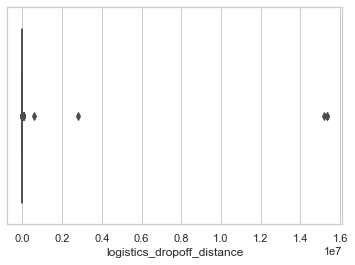

In [11]:

import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=delivery["logistics_dropoff_distance"])

In [12]:
# Outlier detection function < and > than -+ 1.5 IQR 

def filter_outlier(ol):
    Q1 = ol.quantile(0.35)
    Q3 = ol.quantile(0.70)
    IQR = Q3-Q1
    newdf = ol[~((ol < (Q1 - 1.5* IQR)) |(ol > (Q3 + 1.5 * IQR))).any(axis=1)]
    return newdf

In [13]:
# drop outliers for drop-off distance
remove_outlier = filter_outlier(delivery[['logistics_dropoff_distance']])

In [14]:
mask = delivery.index.intersection(remove_outlier.index)

In [15]:
delivery = delivery.loc[mask]

<AxesSubplot:>

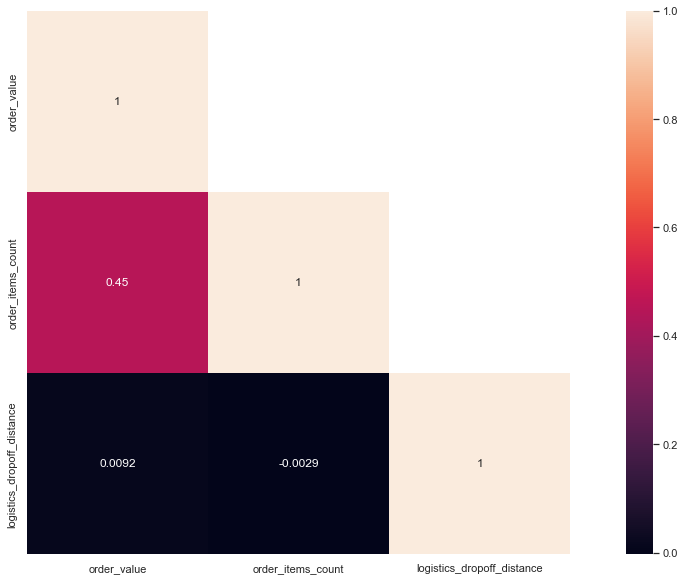

In [16]:
#Observed some correlation between order count and order value. But no significant correlation with logistic_dropoff_distance
cor_d = delivery[["order_value", "order_items_count", "logistics_dropoff_distance"]]

cor_mat= cor_d.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,10)
sns.heatmap(data=cor_mat, mask=mask, square=True, annot=True, cbar=True)

In [17]:
# delivery_geohash_precision8 is difficult to categorise , hence converted to geohash precision level of 5 
delivery['delivery_geohash_precision5'] = delivery['delivery_geohash_precision8'].str[:5]

In [18]:
len(delivery['delivery_geohash_precision5'].unique())

37

In [19]:
delivery['delivery_geohash_precision5']= label.fit_transform(delivery['delivery_geohash_precision5']) 

In [20]:
delivery['delivery_geohash_precision5']

618        36
619        25
620        13
621        19
622        10
           ..
2964434    32
2964435    32
2964436    24
2964437    32
2964438    11
Name: delivery_geohash_precision5, Length: 2323583, dtype: int32

In [21]:
# assigned independent and target variable
X = delivery[['has_instruction', 'has_phone_number', 'has_call_instruction', 'has_leave_instruction', 
              'has_lift_instruction', 'has_lobby_instruction', 'has_gate_instruction', 'has_knock_instruction', 
              'has_bell_instruction', 'order_value', 'order_items_count', 'delivery_geohash_precision5']]

y = delivery["logistics_dropoff_distance"]

In [22]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
#can considered more parameters but due to system constraints using lesser parameter. considering 2 fold
parameters={"splitter":["best","random"],
            "max_depth" : [50, 90, 110, 120],
            "min_samples_leaf":[3, 4, 5],
            "max_features":["sqrt", "auto"],
            "max_leaf_nodes":[5, 8, 10]}

# Modelling 
opt_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters,cv=2,verbose=3)

# Model Fitting
opt_reg.fit(X_train, y_train)

# Predictions
dtm_train = opt_reg.predict(X_train)
dtm_pred = opt_reg.predict(X_test)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=3, splitter=best;, score=0.001 total time=   0.6s
[CV 2/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=3, splitter=best;, score=0.000 total time=   0.5s
[CV 1/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=3, splitter=random;, score=0.001 total time=   0.5s
[CV 2/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=3, splitter=random;, score=0.000 total time=   0.5s
[CV 1/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=4, splitter=best;, score=0.002 total time=   0.8s
[CV 2/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=4, splitter=best;, score=0.001 total time=   0.7s
[CV 1/2] END max_depth=50, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=4, splitter=random;, score=0.001 total time=   0.6s
[CV 2/2] END m

[CV 1/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, splitter=random;, score=0.001 total time=   0.8s
[CV 2/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, splitter=random;, score=0.002 total time=   0.8s
[CV 1/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, splitter=best;, score=0.003 total time=   1.3s
[CV 2/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, splitter=best;, score=0.003 total time=   1.2s
[CV 1/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, splitter=random;, score=0.002 total time=   0.8s
[CV 2/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, splitter=random;, score=0.001 total time=   0.9s
[CV 1/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, splitter=best;, score=0.003 total time=   1.3s
[CV 2/2] END max_depth=50, max_features=auto, max_leaf_nodes=10, min

[CV 1/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=4, splitter=best;, score=0.003 total time=   1.4s
[CV 2/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=4, splitter=best;, score=0.003 total time=   1.3s
[CV 1/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=4, splitter=random;, score=0.002 total time=   0.8s
[CV 2/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=4, splitter=random;, score=0.002 total time=   0.8s
[CV 1/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=5, splitter=best;, score=0.003 total time=   1.5s
[CV 2/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=5, splitter=best;, score=0.003 total time=   1.2s
[CV 1/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_leaf=5, splitter=random;, score=0.001 total time=   0.8s
[CV 2/2] END max_depth=90, max_features=auto, max_leaf_nodes=8, min_samples_l

[CV 1/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=4, splitter=random;, score=0.001 total time=   0.8s
[CV 2/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=4, splitter=random;, score=0.002 total time=   0.7s
[CV 1/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=5, splitter=best;, score=0.002 total time=   1.1s
[CV 2/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=5, splitter=best;, score=0.002 total time=   1.1s
[CV 1/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=5, splitter=random;, score=0.001 total time=   0.7s
[CV 2/2] END max_depth=110, max_features=auto, max_leaf_nodes=5, min_samples_leaf=5, splitter=random;, score=0.001 total time=   0.7s
[CV 1/2] END max_depth=110, max_features=auto, max_leaf_nodes=8, min_samples_leaf=3, splitter=best;, score=0.003 total time=   1.3s
[CV 2/2] END max_depth=110, max_features=auto, max_leaf_nodes=8, min

[CV 1/2] END max_depth=120, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, splitter=best;, score=0.001 total time=   0.5s
[CV 2/2] END max_depth=120, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, splitter=best;, score=0.002 total time=   0.7s
[CV 1/2] END max_depth=120, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, splitter=random;, score=0.001 total time=   0.5s
[CV 2/2] END max_depth=120, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, splitter=random;, score=0.001 total time=   0.5s
[CV 1/2] END max_depth=120, max_features=auto, max_leaf_nodes=5, min_samples_leaf=3, splitter=best;, score=0.002 total time=   1.1s
[CV 2/2] END max_depth=120, max_features=auto, max_leaf_nodes=5, min_samples_leaf=3, splitter=best;, score=0.002 total time=   1.1s
[CV 1/2] END max_depth=120, max_features=auto, max_leaf_nodes=5, min_samples_leaf=3, splitter=random;, score=0.001 total time=   0.7s
[CV 2/2] END max_depth=120, max_features=auto, max_leaf_nodes=5, m

In [24]:
#list of optimal parameters
optimal_para = opt_reg.best_params_
print(optimal_para)

{'max_depth': 90, 'max_features': 'auto', 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'splitter': 'best'}


In [25]:
#Decision tree regression
hyper_para= DecisionTreeRegressor(max_depth=optimal_para['max_depth'],
                                         max_features=optimal_para['max_features'],
                                         max_leaf_nodes=optimal_para['max_leaf_nodes'],
                                         min_samples_leaf=optimal_para['min_samples_leaf'],
                                         splitter=optimal_para['splitter'])

hyper_para.fit(X_train,y_train)
hyper_para_pred = hyper_para.predict(X_test)

In [26]:
# Evaluation Metric
print("RMSE value : ", np.sqrt(mse(y_test, hyper_para_pred)))
print("R-Squared value : ", rsc(y_test, hyper_para_pred))
print("MSE value : ", mse(y_test, hyper_para_pred))
print("MAE value : ", mae(y_test, hyper_para_pred))

RMSE value :  23.239927467876573
R-Squared value :  0.0029996822631087605
MSE value :  540.094228712164
MAE value :  19.092896067426906


In [27]:
# # Due to limited hardware resources passing limited parameters

# parameters={'n_estimators' :[10, 50, 100, 200, 500],
#             'max_features':['auto', 'sqrt'],
#             'max_depth':[20, 50, 70, 90, 110],
#             'min_samples_split':[2, 5, 10],
#             'min_samples_leaf':[1, 2, 4],
#             'bootstrap':[True, False]}

# # Modelling
# rf = RandomForestRegressor()
# rf_grid = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters,cv=2,verbose=3)

# # Model Fitting
# rf_grid.fit(X_train, y_train)

# # Predictions
# rf_grid_pred = rf.predict(X_test)

In [28]:
# Passing fixed parameter due to performance constrained
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

# Model Fitting
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [29]:
# Predict
rf_pred = rf.predict(X_test)

In [35]:
# # feature importance
coef = pd.DataFrame(rf.feature_importances_)
print(coef)

           0                         feat
0   0.010716              has_instruction
1   0.016471             has_phone_number
2   0.024290         has_call_instruction
3   0.025211        has_leave_instruction
4   0.012579         has_lift_instruction
5   0.001557        has_lobby_instruction
6   0.017800         has_gate_instruction
7   0.015118        has_knock_instruction
8   0.014435         has_bell_instruction
9   0.652889                  order_value
10  0.161212            order_items_count
11  0.047722  delivery_geohash_precision5


In [31]:
#Model Evaluation Metric
print("RMSE value : ", np.sqrt(mse(y_test, rf_pred)))
print("R-Squared value : ", rsc(y_test, rf_pred))
print("MSE value : ", mse(y_test, rf_pred))
print("MAE value : ", mae(y_test, rf_pred))

RMSE value :  24.76643214554719
R-Squared value :  -0.13227691598696567
MSE value :  613.3761612199932
MAE value :  20.104237507133625


Looking at above model decision tree looks seemed to be best fit due to low MSE and MAE . 
However, I wanted to implement for XGboost. Due to time constraint and low performance system skipping as of now

In [45]:
#Considering the important feature affecting good and bad delivery
data = delivery[['order_value', 'order_items_count','logistics_dropoff_distance', 'has_call_instruction']]
data.head()

,order_value,order_items_count,logistics_dropoff_distance,has_call_instruction
618,40.44,10,58.656138,0
619,35.60,10,39.025148,0
620,42.49,12,40.067811,0
621,14.40,11,44.986785,0
622,38.15,10,71.520828,0


In [79]:
#Assuming bad delivery, where drop-off distance more than 75% percentile
delivery['Category'] = np.where(data['logistics_dropoff_distance'] < 63 , 'Good', 'Bad')

In [80]:
delivery.head()

,order_id,order_value,order_items_count,customer_id,created_timestamp_local,has_instruction,logistics_dropoff_distance,delivery_postal_code,delivery_geohash_precision8,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,delivery_geohash_precision5,Category
618,b8ds-tqhf,40.44,10,h6huq0td,2021-03-11T20:19:50,1,58.656138,828868,w23bh248,0,0,0,0,0,0,0,0,36,Good
619,x5xx-j2d2,35.60,10,t2nod4rq,2021-03-12T18:42:48,1,39.025148,530548,w21zu55k,0,0,0,0,0,0,0,0,25,Good
620,x6qu-14kt,42.49,12,m4ycd3tm,2021-03-27T11:29:17,1,40.067811,650248,w21z9jc4,0,0,1,0,0,0,0,0,13,Good
621,x3yw-rhc5,14.40,11,sgmnf9sb,2021-03-02T22:08:52,1,44.986785,550105,w21zg97y,0,0,0,0,0,0,0,0,19,Good
622,y9zp-58q7,38.15,10,x4rvv3iy,2021-03-23T20:35:26,1,71.520828,102112,w21z61q6,0,0,0,0,0,0,0,0,10,Bad


In [ ]:
#Further classification model also can be built to predict good and bad delivery